In [245]:
import openmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

In [2]:
# some constants
thermal_power = 354e6 #watts, J/s
eV_to_J = 1.60218e-19 #joules/eV
average_neutron_energy = 2e6*eV_to_J #J/n, doesn't really matter for heating
neutrons_per_second = thermal_power/average_neutron_energy #n/s
core_height = 89
core_radius = 29.5275

In [3]:
# Grab all the Data from the StatePoint file
sp_file = "statepoint.80.h5"
with openmc.StatePoint(sp_file) as sp:
    fuel_flux_tally = sp.get_tally(name='Flux')
    fuel_heating_tally = sp.get_tally(name='Heating')
    axial_flux_tally = sp.get_tally(name='Axial Flux Tally')
    runtime = sp.runtime
    particles = sp.n_particles
    batches = sp.n_batches
    dfs = {}
    for key in sp.tallies:
        dfs[sp.tallies[key].name] = sp.tallies[key].get_pandas_dataframe()
    

In [4]:
time = runtime['total']
pps = (particles*batches)/time
pps

19512.25801807305

In [5]:
fuel_flux_mean = fuel_flux_tally.get_reshaped_data('mean')
fuel_flux_stddev = fuel_flux_tally.get_reshaped_data('std_dev')
fuel_flux_rel_err = fuel_flux_stddev/fuel_flux_mean
np.max(fuel_flux_rel_err)

0.05450718476174679

In [6]:
fuel_heating_mean = fuel_heating_tally.get_reshaped_data('mean').flatten() #eV/source
total_heating = np.sum(fuel_heating_mean) #eV/source
fuel_heating_watts = (fuel_heating_mean/total_heating)*thermal_power #percent of total heating/source, or heating per element, watts


fuel_heating_stddev = fuel_heating_tally.get_reshaped_data('std_dev').flatten()
fuel_heating_rel_err = fuel_heating_stddev/fuel_heating_mean
np.max(fuel_heating_rel_err) 

0.0009150369923387592

In [7]:
total_heating

79447567.53335121

In [8]:
fuel_heating_watts.max()

734502.1954769904

In [9]:
fuel_heating_mean.shape

(564,)

In [10]:
axial_flux_mean = axial_flux_tally.get_reshaped_data('mean')
axial_flux_stddev = axial_flux_tally.get_reshaped_data('std_dev')
axial_flux_rel_err = axial_flux_stddev/axial_flux_mean
np.max(axial_flux_rel_err)

0.007271939882930556

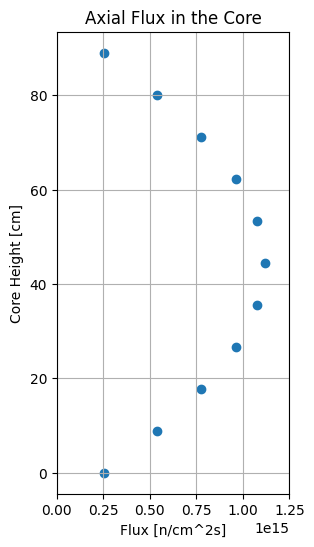

In [22]:
# Plot the Axial Flux:
z_values = dfs["Axial Flux Tally"].loc[:, ('mesh 2', 'z')]
combined_fluxes = dfs["Axial Flux Tally"].groupby(z_values)
fluxes = combined_fluxes["mean"].sum()
axial_heights = core_height * np.linspace(0,1,11)

# Mesh is defined between height = -core_height/2, core_height/2 radius = 29.5275 cm
core_volume = np.pi * core_radius**2 * core_height 

normalized_fluxes = fluxes * ((thermal_power / (eV_to_J * total_heating))/core_volume)

plt.figure(figsize=(3,6))

plt.scatter(normalized_fluxes, axial_heights)
plt.grid()
plt.title("Axial Flux in the Core")
plt.xlabel("Flux [n/cm^2s]")
plt.ylabel("Core Height [cm]")
plt.xlim(0,1.25e15)
plt.show()

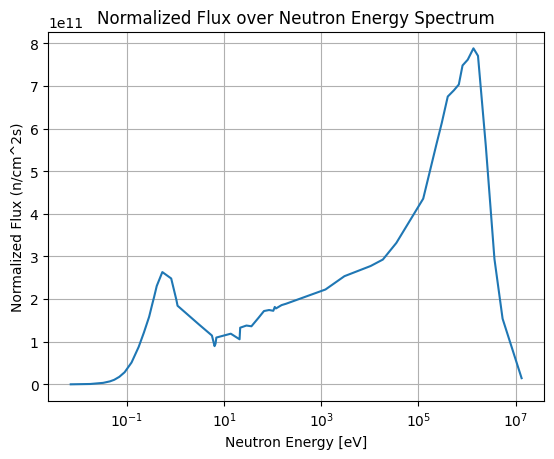

In [121]:
# Plot the Flux Spectrum in one of the fuel elements
low_energy_groups = dfs["Flux"].loc[dfs["Flux"]["distribcell"]==0]["energy low [eV]"]
high_energy_groups = dfs["Flux"].loc[dfs["Flux"]["distribcell"]==0]["energy high [eV]"]
flux_by_energy = dfs["Flux"].loc[dfs["Flux"]["distribcell"]==0]["mean"]
correct_units_flux_by_energy = flux_by_energy * ((thermal_power / (eV_to_J * total_heating))/core_volume)
normalized_flux_by_energy = correct_units_flux_by_energy/np.log(high_energy_groups/low_energy_groups)
midpoint_energy_groups = (high_energy_groups-low_energy_groups)/2+low_energy_groups


plt.semilogx(midpoint_energy_groups, normalized_flux_by_energy)
plt.title("Normalized Flux over Neutron Energy Spectrum")
plt.xlabel("Neutron Energy [eV]")
plt.ylabel("Normalized Flux (n/cm^2s)")
plt.grid()
plt.show()

In [191]:
dfs["Heating"]

level 1      level 2      level 3      level 4         level 5       \
       univ cell    univ cell    univ cell     lat            univ cell   
         id   id      id   id      id   id      id   x   y      id   id   
0        10   31       8   20       7   19       6   7 -17       1    3   
1        10   31       8   20       7   19       6   8 -17       1    3   
2        10   31       8   20       7   19       6   9 -17       1    3   
3        10   31       8   20       7   19       6  10 -17       1    3   
4        10   31       8   20       7   19       6   3 -16       1    3   
..      ...  ...     ...  ...     ...  ...     ...  ..  ..     ...  ...   
559      10   31       8   20       7   19       6  -3  16       1    3   
560      10   31       8   20       7   19       6 -10  17       1    3   
561      10   31       8   20       7   19       6  -9  17       1    3   
562      10   31       8   20       7   19       6  -8  17       1    3   
563      10   31       8   20       7   19       6  -7  17       1    3   

    distribcell nuclide          score     mean std. dev.  
                                                           
                                                           
0             0   total  kappa-fission 1.52e+05  1.04e+02  
1             1   total  kappa-fission 1.48e+05  1.17e+02  
2             2   total  kappa-fission 1.47e+05  1.06e+02  
3             3   total  kappa-fission 1.49e+05  1.08e+02  
4             4   total  kappa-fission 1.63e+05  1.05e+02  
..          ...     ...            ...      ...       ...  
559         559   total  kappa-fission 1.64e+05  1.17e+02  
560         560   total  kappa-fission 1.52e+05  1.03e+02  
561         561   total  kappa-fission 1.50e+05  1.19e+02  
562         562   total  kappa-fission 1.49e+05  1.11e+02  
563         563   total  kappa-fission 1.50e+05  1.01e+02  

[564 rows x 16 columns]